#### Dataset perpration
inlcudes cutting, foldering and seperating test

In [3]:
# %tensorflow_version 1.x
import datetime
print(f'Start: {datetime.datetime.now()}')
%pwd
%ls

Start: 2020-07-23 13:47:17.555907
 Volume in drive C has no label.
 Volume Serial Number is 3839-F69A

 Directory of C:\Users\Worker\Desktop\computer-vision

2020-07-23  01:28 PM    <DIR>          .
2020-07-23  01:28 PM    <DIR>          ..
2020-07-23  01:27 PM    <DIR>          .ipynb_checkpoints
2020-07-23  01:23 PM    <DIR>          dataset
2020-07-23  01:24 PM    <DIR>          model_bkp
               0 File(s)              0 bytes
               5 Dir(s)  128,900,378,624 bytes free


In [10]:
from tqdm import tqdm
import numpy as np
import cv2
import glob
import os
from cv2 import aruco
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def flatten_photo(dict_arco, width, height, image_path):
    """flatten phto using aurco dictinary to given size
    dict_arco must follow as 
    {
        topleft  : 0
        topright : 1
        botright : 2
        botleft  : 3
    }

    Args:
        dict_arco (dict): arco dictonary
        width (int): width of warped picture
        height (int): height of warped picture
        image_path (string): image to read

    Returns:
        cv.image: warped image
    """
    try:
      I_orginal = cv2.imread(image_path)
      # ARUCO finding process
      gray = cv2.cvtColor(I_orginal, cv2.COLOR_BGR2GRAY)
      aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
      parameters = aruco.DetectorParameters_create()
      corners, ids, rejectedImgPoints = aruco.detectMarkers(
          gray, aruco_dict, parameters=parameters)
      source_points = np.zeros((4, 2), dtype=np.dtype('int32'))
      if len(ids) != 4:
          print("Less than 4 aruco", imgPath)
          return None
      for i in range(4):
          id = ids[i][0]
          corn = dict_arco[id]
          x = corners[i][0][corn][0]
          y = corners[i][0][corn][1]
          point = (x, y)
          source_points[corn][0] = x
          source_points[corn][1] = y

      dest_points = np.array([
          (0, 0),
          (width, 0),
          (width, height),
          (0, height), ])

      H, mask = cv2.findHomography(source_points, dest_points, cv2.RANSAC, 4.0)
      J_warped = cv2.warpPerspective(I_orginal, H, (width, height))
    except:
      print(f"ERROR: path:{image_path}")
      return None
    return J_warped

In [6]:

dict_arco = {
    30: 0,
    31: 1,
    33: 2,
    32: 3,
}

size = 32  # size of each cell (pixel)
with_no = 14  # number of cells in row/width
height_no = 21  # number of cells in column/height
test_ration = 0.05

raw_dir = "dataset/raw/"
processed_dir = "dataset/processed/"
test_dir = "dataset/test/"

list_items_1 = [
    ["no_0", 10, "۰"],
    ["no_1", 10, "۱"],
    ["al_al", 14, "ا"],
    ["al_be", 14, "ب"],
    ["al_pe", 14, "پ"],
    ["al_te", 14, "ت"],
    ["al_sn", 14, "ث"],
    ["al_jm", 14, "ج"],
    ["al_ch", 14, "چ"],
    ["al_hh", 14, "ح"],
    ["al_kh", 14, "خ"],
    ["al_dl", 14, "د"],
    ["al_zl", 14, "ذ"],
    ["al_rr", 14, "ر"],
    ["al_zz", 14, "ز"],
    ["al_jz", 14, "ژ"],
    ["al_sn", 14, "س"],
    ["al_shn", 14, "ش"],
    ["al_sd", 14, "ص"],
    ["no_2", 10, "۲"],
    ["no_3", 10, "۳"]]

list_items_2 = [
    ["no_4", 10, "۴"],
    ["no_5", 10, "۵"],
    ["al_zd", 14, "ض"],
    ["al_ta", 14, "ط"],
    ["al_za", 14, "ظ"],
    ["al_ay", 14, "ع"],
    ["al_ghy", 14, "غ"],
    ["al_fe", 14, "ف"],
    ["al_gh", 14, "ق"],
    ["al_kf", 14, "ک"],
    ["al_gf", 14, "گ"],
    ["al_lm", 14, "ل"],
    ["al_mm", 14, "م"],
    ["al_nn", 14, "ن"],
    ["al_vv", 14, "و"],
    ["al_he", 14, "ه"],
    ["al_ye", 14, "ی"],
    ["no_6", 14, "۶"],
    ["no_7", 14, "۷"],
    ["no_8", 10, "۸"],
    ["no_9", 10, "۹"]]

In [81]:
fnames_1 = glob.glob(f"{raw_dir}/*_1*.jpg")
fnames_2 = glob.glob(f"{raw_dir}/*_2*.jpg")
fnames_1.sort()
fnames_2.sort()

print(f"Class 1:{len(fnames_1)}")
print(f"Class 2:{len(fnames_2)}")
fs = [fnames_1, fnames_2]
ls = [list_items_1, list_items_2]
# fs = [fnames_1, fnames_2]
# ls = [list_items_1, list_items_2]

Class 1:25
Class 2:22


In [82]:
# class_1 = np.zeros((len(fnames_1)))
# class_2 = np.zeros((len(fnames_2)))

for fnames, list_items in zip(fs, ls):
    class_pic = np.zeros((len(fnames)),dtype=object)
    pic_names = np.zeros((len(fnames)),dtype=object)
    index = -1
    for image_path in tqdm(fnames, desc="Image Read"):
        index = index + 1
         
        f_name = image_path.split(os.path.sep)[-1].split('.')[0]
        J_warped = flatten_photo(dict_arco, size*with_no, size*height_no, image_path)
        class_pic[index] = J_warped
        pic_names[index] = f_name
        if J_warped is None:
            print(f"Skipped {image_path}")
            continue
    print("read ",class_pic.size,"pictures")
    array_items = np.zeros((len(list_items)),dtype=object)
    for it in range(len(list_items)):
        array_items[it] = []

    for pic, name in tqdm(zip(class_pic,pic_names),desc="Image Slice"):
        for row in range(len(list_items)):
            tmp = list_items[row][1]
            y0 = int(row * size)
            y1 = int(y0 + size)
            y0 = y0+2
            y1 = y1-2
            for col in range(tmp):
                offs =  int(7 - tmp/2)
                x0 = int((offs + col) * size) 
                x1 = int(x0 + size)
                x0 = x0+2
                x1 = x1-2
                block = pic[y0:y1, x0:x1]
                array_items[row].append((block,name))
    print("===========END OF FOLDER==============")
    for item in range(len(list_items)):
        # print(f"Processing {list_items[item][2]}")
        print(f"for {list_items[item][2]} got {len(array_items[item])} blocks" )
        train_input, valid_input = train_test_split(array_items[item],
                                                    test_size=test_ration, random_state=103)
        #Save train data
        save_dir = f"{processed_dir}{list_items[item][0]}__/"
        ensure_dir(save_dir)
        for i in range(len(train_input)):
            cv2.imwrite(f"{save_dir}{train_input[i][1]}_{i}.jpg", train_input[i][0]);
        
        #Save test data
        save_dir = f"{test_dir}{list_items[item][0]}__/"
        ensure_dir(save_dir)
        for i in range(len(valid_input)):
            cv2.imwrite(f"{save_dir}{valid_input[i][1]}_{i}.jpg", valid_input[i][0]);    
            
        
        # for row in tqdm(len(list_items), desc="item"):
        #     tmp = list_items[row][1]
        # 
        #     y0 = int(row * size)
        #     y1 = int(y0 + size)
        # 
        #     y0 = y0+2
        #     y1 = y1-2
        #     for col in range(tmp):
        #         offs =  int(7 - tmp/2)
        # 
        #         x0 = int((offs + col) * size) 
        #         x1 = int(x0 + size)
        #         x0 = x0+2
        #         x1 = x1-2
        # 
        #         tmp_arr = J_warped[y0:y1, x0:x1]
        #         save_dir = f"{processed_dir}{list_items[row][0]}__/"
        #         ensure_dir(save_dir)
        #         cv2.imwrite(f"{save_dir}{f_name}_{col}.jpg", tmp_arr)


Image Read: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.11it/s]
Image Slice: 25it [00:00, ?it/s]
Image Read: 100%|██████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  9.61it/s]
Image Slice: 22it [00:00, ?it/s]


read  25 pictures
===========END OF FOLDER==============
for ۰ got 250 blocks
for ۱ got 250 blocks
for ا got 350 blocks
for ب got 350 blocks
for پ got 350 blocks
for ت got 350 blocks
for ث got 350 blocks
for ج got 350 blocks
for چ got 350 blocks
for ح got 350 blocks
for خ got 350 blocks
for د got 350 blocks
for ذ got 350 blocks
for ر got 350 blocks
for ز got 350 blocks
for ژ got 350 blocks
for س got 350 blocks
for ش got 350 blocks
for ص got 350 blocks
for ۲ got 250 blocks
for ۳ got 250 blocks
read  22 pictures
===========END OF FOLDER==============
for ۴ got 220 blocks
for ۵ got 220 blocks
for ض got 308 blocks
for ط got 308 blocks
for ظ got 308 blocks
for ع got 308 blocks
for غ got 308 blocks
for ف got 308 blocks
for ق got 308 blocks
for ک got 308 blocks
for گ got 308 blocks
for ل got 308 blocks
for م got 308 blocks
for ن got 308 blocks
for و got 308 blocks
for ه got 308 blocks
for ی got 308 blocks
for ۶ got 308 blocks
for ۷ got 308 blocks
for ۸ got 220 blocks
for ۹ got 220 blocks


(28, 28, 3)
2
2


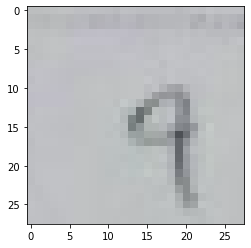

In [65]:
print((train_input[0][0].shape))
print(len(train_input[0]))
print(len(valid_input[0]))

# plt.imshow(train_input[0][0])
plt.imshow(valid_input[0][0])

# plt.imshow(array_items[2][60])